In [1]:
import time
import operator
from typing import NamedTuple
import numpy as np
import matplotlib.pyplot as plt
import math

# Part I: Environment Definition

## Question 1

Since the robot is a point robot in a two-dimensional space, its coordinates in the workspace are exactly the degrees of freedom controlled in the configuration space; therefore, no transformation is necessary. 

In [2]:
class Config(NamedTuple):
    x: float
    y: float

## Question 2

In [3]:
config1 = Config(2, 3)
config2 = Config(4, 6)
# Euclidean distance between config1 and config2:
dist = np.sqrt(np.sum(np.square(np.array(config1) - np.array(config2))))
print(dist)

3.605551275463989


In [4]:
class MapEnvironment:

    def __init__(self, mapfile):

        # Obtain the boundary limits
        self.map = np.loadtxt(mapfile)
        self.xlimit = [0, np.shape(self.map)[1] - 1]
        self.ylimit = [0, np.shape(self.map)[0] - 1]

        self._show_map()

    def _show_map(self):
        plt.imshow(self.map, interpolation='nearest')
        plt.xlabel('x')
        plt.ylabel('y')

    def compute_distance(self, start_config, end_config):
        return math.sqrt((start_config.x - end_config.x)**2 + (start_config.y - end_config.y)**2)
        # The following are both (surprisingly?) slower
        # return np.sqrt(np.square(start_config.x - end_config.x) + np.square(start_config.y - end_config.y))
        # return np.sqrt(np.sum(np.square(np.array(start_config) - np.array(end_config))))

    def check_state_validity(self, config):
        # check within limit
        if config.x < self.xlimit[0] or config.x > self.xlimit[1] or \
                config.y < self.ylimit[0] or config.y > self.ylimit[1]:
            return False
        # check collision (built-in round is faster than np.round)
        # x, y = int(np.round(config.x)), int(np.round(config.y))
        x, y = int(round(config.x)), int(round(config.y))
        return not self.map[y][x]

    def check_edge_validity(self, config1, config2, visualize=False, pts=50):
        if visualize:
            self._show_map()
            plt.plot(config1.x, config1.y, 'o', color='w')
            plt.plot(config2.x, config2.y, 'o', color='w')
            plt.plot([config1.x, config2.x], [config1.y, config2.y], color='w')

        # Check validity of pts equally spaced points along the edge
        arr = np.linspace(0, 1, pts)
        np.random.shuffle(arr)
        for alpha in arr:
            new_x = alpha * config1.x + (1.0 - alpha) * config2.x
            new_y = alpha * config1.y + (1.0 - alpha) * config2.y
            if not self.check_state_validity(Config(new_x, new_y)):
                return False

        return True

    def visualize_plan(self, plan):
        self._show_map()
        plt.plot(plan[0].x, plan[0].y, 'o', color='g')
        plt.plot(plan[-1].x, plan[-1].y, 'o', color='r')
        for first_config, second_config in zip(plan, plan[1:]):
            plt.plot([first_config.x, second_config.x], [first_config.y, second_config.y], color='w')
        plt.show()

## Question 3

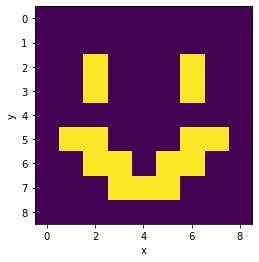

In [5]:
MapEnvironment('map3.txt')

## Question 4

Distance between Config(x=3.711853704552933, y=0.8177725454201035) and Config(x=7.977661288139527, y=5.54485267605352) is 6.367291488664088


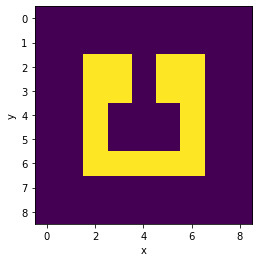

In [6]:
# Compute distance between two arbitrary configurations in map1
env = MapEnvironment('map1.txt')
x1, x2 = np.random.uniform(low=env.xlimit[0], high=env.xlimit[1], size=2)
y1, y2 = np.random.uniform(low=env.ylimit[0], high=env.ylimit[1], size=2)
config1 = Config(x1, y1)
config2 = Config(x2, y2)
dist = env.compute_distance(config1, config2)

print(f"Distance between {config1} and {config2} is {dist}")

## Question 5

True


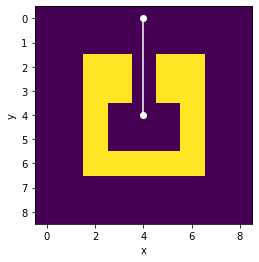

In [7]:
# Valid edge example:
env = MapEnvironment('map1.txt')
print(env.check_edge_validity(Config(4,0), Config(4,4), visualize=True))


False


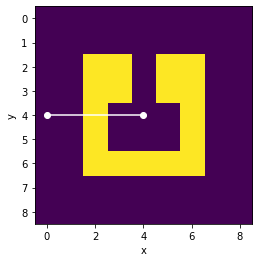

In [21]:
# Invalid edge example:
env = MapEnvironment('map1.txt')
print(env.check_edge_validity(Config(4, 4), Config(0, 4), visualize=True))

## Question 6

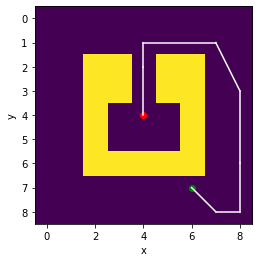

In [8]:
planning_env = MapEnvironment('map1.txt')
# plan = [Config(6, 7), Config(7, 8), Config(8, 8), Config(8, 6), Config(8, 3),
#         Config(7, 3), Config(7, 1), Config(6, 0), Config(4, 1), Config(4, 2), Config(4, 4)]
plan = [Config(6, 7), Config(7, 8), Config(8, 8), Config(8, 6), Config(8, 3),
        Config(7, 1), Config(4, 1), Config(4, 2), Config(4, 4)]
planning_env.visualize_plan(plan)
# The uncommented plan is modified from the original, commented plan

# Part II: RRT

In [9]:
class RRTTree:

    def __init__(self, planning_env):
        self.planning_env = planning_env
        self.vertices = []
        self.edges = dict()

    def get_root_id(self):
        return 0

    def get_nearest_vertex(self, config):
        dists = []
        for v in self.vertices:
            dists.append(self.planning_env.compute_distance(config, v))

        vid, vdist = min(enumerate(dists), key=operator.itemgetter(1))

        return vid, self.vertices[vid]

    def add_vertex(self, config):
        vid = len(self.vertices)
        self.vertices.append(config)
        return vid

    def add_edge(self, sid, eid):
        self.edges[eid] = sid

In [10]:
class RRTPlanner(object):

    def __init__(self, planning_env):
        self.planning_env = planning_env
        self.tree = RRTTree(self.planning_env)

    def sample_random_config(self, goal_pose=None, r=1.0):
        if goal_pose is None:
            low_x, high_x = self.planning_env.xlimit
            low_y, high_y = self.planning_env.ylimit
        else:
            low_x = max(goal_pose.x - r, self.planning_env.xlimit[0])
            high_x = min(goal_pose.x + r, self.planning_env.xlimit[1])
            low_y = max(goal_pose.y - r, self.planning_env.ylimit[0])
            high_y = min(goal_pose.y + r, self.planning_env.ylimit[1])

        x = np.random.uniform(low=low_x, high=high_x)
        y = np.random.uniform(low=low_y, high=high_y)
        return Config(x, y)

    def extend_and_check(self, home, target, eta):
        x_new = (1.0 - eta) * home.x + eta * target.x
        y_new = (1.0 - eta) * home.y + eta * target.y
        if self.planning_env.check_edge_validity(home, Config(x_new, y_new)):
            return Config(x_new, y_new)
        else:
            return None

    def post_process(self, plan, pp_steps=25):
        for _ in range(pp_steps):
            if len(plan) < 3:
                return plan
            vid = np.random.choice(np.arange(1, len(plan) - 1))
            v = plan[vid]
            v_prev = plan[vid - 1]
            v_next = plan[vid + 1]
            last_points = []
            edges = True
            for ind, eta in enumerate(np.linspace(1, 0, 10)):
                p_prev = Config((1.0 - eta) * v.x + eta * v_prev.x, (1.0 - eta) * v.y + eta * v_prev.y)
                p_next = Config((1.0 - eta) * v.x + eta * v_next.x, (1.0 - eta) * v.y + eta * v_next.y)
                segment_length = self.planning_env.compute_distance(p_prev, p_next)
                found = self.planning_env.check_edge_validity(p_prev, p_next, pts=100 * int(np.ceil(segment_length)))
                if found:
                    last_points = [p_prev, p_next]
                    break
                edges = False

            if len(last_points):
                del plan[vid]
                if not edges:
                    plan[vid:vid] = last_points

        return plan

    def plan(self, start_config, goal_config, eta=0.3, max_iterations=10000, bias_thresh=0.01, second_try=False):

        if 'adaptive' == eta:
            adaptive = True
            eta = 0.5
        else:
            adaptive = False

        # Initialize an empty plan
        plan = []

        # Start with adding the start configuration to the tree
        self.tree.add_vertex(start_config)

        goal_id = -1
        streak = 0
        # Main search loop
        for step in range(max_iterations):
            x_rand = self.sample_random_config(goal_pose=(goal_config if np.random.uniform() < bias_thresh else None))
            near_id, x_near = self.tree.get_nearest_vertex(x_rand)
            x_new = self.extend_and_check(x_near, x_rand, eta)
            if x_new is not None:
                new_id = self.tree.add_vertex(x_new)
                self.tree.add_edge(near_id, new_id)
                if adaptive:
                    if streak > 0:
                        streak = -1
                    elif -10 < streak <= 0:
                        streak -= 1
                    else:
                        eta = 1.1 * eta
                        if eta > 1.0:
                            eta = 1.0
                        streak = 0
            else:
                if adaptive:
                    if streak < 0:
                        streak = 1
                    elif 0 <= streak < 100:
                        streak += 1
                        if not streak % 10:
                            eta = 0.9 * eta
                            if eta < 0.001:
                                eta = 0.001
                    else:
                        break
                continue

            if self.planning_env.check_edge_validity(x_new, goal_config):
                goal_id = self.tree.add_vertex(goal_config)
                self.tree.add_edge(new_id, goal_id)
                break

        if goal_id > 0:
            end_id = goal_id
            while end_id:
                end_v = self.tree.vertices[end_id]
                plan.insert(0, end_v)

                # Greedy smoothing to shorten path if possible
                start_id = self.tree.edges[end_id]
                while start_id:
                    new_start_id = self.tree.edges[start_id]
                    if self.planning_env.check_edge_validity(end_v, self.tree.vertices[new_start_id]):
                        start_id = new_start_id
                    else:
                        break
                end_id = start_id

            plan.insert(0, self.tree.vertices[0])
            plan = self.post_process(plan)
            return plan
        elif not goal_id:
            plan.append(goal_config)
            return plan
        else:
            # if second_try:
            #     return None
            # else:
            #     res = self.plan(start_config, goal_config, eta, max_iterations, bias_thresh, second_try=True)
            #     print(f'Res is {res if not res else True} on second try')
            #     return res
            return None

# Evaluation

In [11]:
def evaluate(planning_env, start, goal):
    
    planner = RRTPlanner(planning_env)

    ts = time.time()
    plan = planner.plan(start, goal)
    tf = time.time()   
    duration = tf - ts

    if plan is None:
        raise Exception('No path found')
    
    if plan[0] != start or plan[-1] != goal:
        raise Exception('Wrong path')
        
    total_cost = 0
    invalid_samples = 0
    total_samples = 0
    for segment in zip(plan, plan[1:]):
        first_config, second_config = segment
        segment_length = planning_env.compute_distance(first_config, second_config)
        total_cost += segment_length
        for _ in range(100 * int(np.ceil(segment_length))):
            a = np.random.uniform(0, 1)       
            sample_x = a * first_config.x + (1 - a) * second_config.x
            sample_y = a * first_config.y + (1 - a) * second_config.y
            sample_config = Config(sample_x, sample_y)
            total_samples += 1
            if not planning_env.check_state_validity(sample_config):
                invalid_samples += 1
    planning_env.visualize_plan(plan)
    invalidity_ratio = invalid_samples / total_samples
    return invalidity_ratio, total_cost, duration

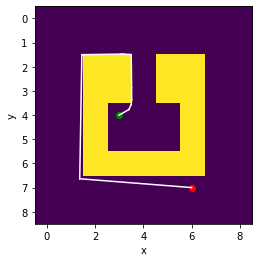

Invalidity: 0.0, Cost: 14.578167772425399, Duration: 0.136214017868042


In [12]:
invalidity_ratio, total_cost, duration = evaluate(MapEnvironment('map1.txt'), start=Config(3, 4), goal=Config(6, 7))
print(f'Invalidity: {invalidity_ratio}, Cost: {total_cost}, Duration: {duration}')

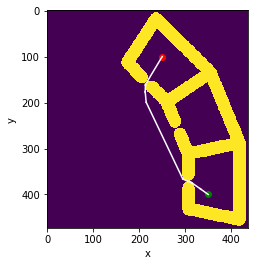

Invalidity: 0.0, Cost: 359.9960386882462, Duration: 1.3406641483306885


In [13]:
invalidity_ratio, total_cost, duration = evaluate(MapEnvironment('map2.txt'), start=Config(350, 400), goal=Config(250, 100))
print(f'Invalidity: {invalidity_ratio}, Cost: {total_cost}, Duration: {duration}')